<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/generative-artificial-intelligence/02_diffusion_model_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

In [2]:
image_size = 32
batch_size = 64
number_of_timesteps = 30
time_scale_array = 1 - np.linspace(0, 1.0, number_of_timesteps + 1)

In [3]:
device = torch.device('cuda')

## Step 2: Data Preprocessing

In [4]:
mnist_image_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=mnist_image_transform
)

In [ ]:
index_for_7 = [i for i, (img, label) in enumerate(dataset) if label == 7]
subset_training = torch.utils.data.Subset(dataset, index_for_7)

traindata_loader = torch.utils.data.DataLoader(
    subset_training,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

## Step 3: Model Training

In [7]:
def add_stepwise_forward_noise(x_img, t_step):
    p = time_scale_array[t_step]
    q = time_scale_array[t_step + 1]

    noise = np.random.normal(size=x_img.shape)
    p = p.reshape((-1, 1, 1, 1))
    q = q.reshape((-1, 1, 1, 1))
    img_p = x_img * (1 - p) + noise * p
    img_q = x_img * (1 - q) + noise * q
    return img_p, img_q

In [8]:
def generate_random_timesteps(num):
    return np.random.randint(0, number_of_timesteps, size=num)

In [9]:
def display_image_grid(image):
    image = image.permute([0, 2, 3, 1])
    image = image - image.min()
    image = (image / image.max())
    return image.numpy().astype(np.float32)

def normalize_and_convert(x):
    plt.figure(figsize=(10, 10))
    imgs = display_image_grid(x)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

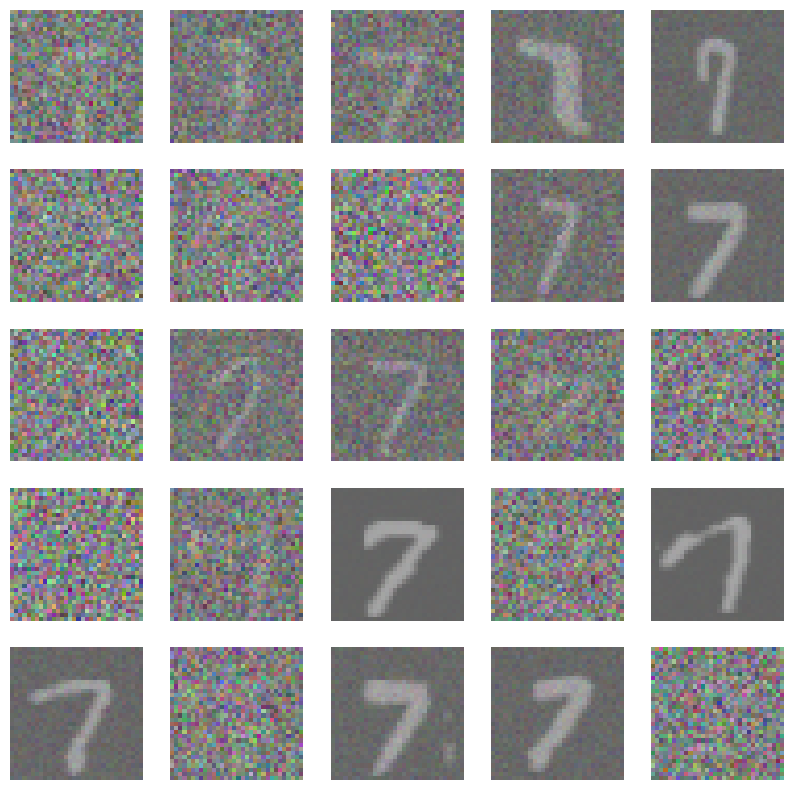

In [10]:
rand_tsteps = generate_random_timesteps(25)
x, _ = next(iter(traindata_loader))

p, q = add_stepwise_forward_noise(x[:25], rand_tsteps)
normalize_and_convert(p)